<a href="https://colab.research.google.com/github/Musu1/Atlan_assignment_submission/blob/master/submission_atlan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [64]:
# Installing overpy
# overpy - a python frontend for overpass API of OSM
pip install overpy

In [0]:
import overpy

In [0]:
# Overpass API to frame queries for extracting data from OSM
api=overpy.Overpass()

# Important URLs
1. Tag Info API - https://taginfo.openstreetmap.org/tags
2. Overpass API documentation - https://wiki.openstreetmap.org/wiki/Overpass_API/Overpass_QL
3. Overpass API with query examples - https://wiki.openstreetmap.org/wiki/Overpass_API/Overpass_API_by_Example
4. Loading data from OSM with python - https://towardsdatascience.com/loading-data-from-openstreetmap-with-python-and-the-overpass-api-513882a27fd0
5. All the amenities list - https://wiki.openstreetmap.org/wiki/Key:amenity
6. Overpass API - http://overpass-turbo.eu/
7. Amazing documentation - https://buildmedia.readthedocs.org/media/pdf/python-overpy/latest/python-overpy.pdf

# **Objective-1** 
Get Points of Interest from open data sources like open street maps (OSM)

In [0]:
# Framing Overpass query to extract the POI's of a city
# City chosen - Mumbai
# POI - Latitude + Longitude + Tag of the place 

r = api.query("""
(
  area[name="Mumbai"];
  node["amenity"]["name"](area);
);
out body;
>;
out skel qt;
""")
# Node will give all the centers of the city(Mumbai)
# Used amenity and name with node because otherwise it would also list longitude and latitudes without any amenity(center) name
#This way only centers with amenity name would be displayed


In [0]:
# Extracting needed information from data extarcted
# We only wanted latitude ,longitude and amenity(center) name 
# Here node will have lat and long information 
# And node.tags is a dictionary and we only want amenity name from dictionary so iterated in this way
coords  = []
for node in r.nodes:
  for keys in node.tags:
    if keys=="amenity":
      x=node.tags[keys]
    coords += [(float(node.lon), float(node.lat),x)]

In [69]:
coords

[(72.8325747, 18.927571, 'restaurant'),
 (72.8325747, 18.927571, 'restaurant'),
 (72.8325747, 18.927571, 'restaurant'),
 (72.8272935, 18.942228, 'parking'),
 (72.8272935, 18.942228, 'parking'),
 (72.8272935, 18.942228, 'parking'),
 (72.8269, 18.9424, 'parking'),
 (72.8269, 18.9424, 'parking'),
 (72.8269, 18.9424, 'parking'),
 (72.8369017, 18.9567022, 'parking'),
 (72.8369017, 18.9567022, 'parking'),
 (72.8369017, 18.9567022, 'parking'),
 (72.8058471, 18.9643233, 'parking'),
 (72.8058471, 18.9643233, 'parking'),
 (72.8058471, 18.9643233, 'parking'),
 (72.8936069, 19.0611444, 'hospital'),
 (72.8936069, 19.0611444, 'hospital'),
 (72.8936069, 19.0611444, 'hospital'),
 (72.8417264, 19.0879905, 'parking'),
 (72.8417264, 19.0879905, 'parking'),
 (72.8417264, 19.0879905, 'parking'),
 (72.8505495, 19.0934661, 'parking'),
 (72.8505495, 19.0934661, 'parking'),
 (72.8505495, 19.0934661, 'parking'),
 (72.8501748, 19.1174006, 'parking'),
 (72.8501748, 19.1174006, 'parking'),
 (72.8501748, 19.1174006

# **Objective 2**

Understand how spatial location data works
1. Understand spatial vector data types and how to manipulate it using your
language of choice.
2. Understand necessary GIS concepts like projections, spatial clustering, etc

# **Objective 3**
Figure out a way of clustering these points into commercial centers/markets. You can
use standard size polygons also to cluster the points.

In [0]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint

In [71]:
type(coords)

list

In [0]:
# Converting the data into data frame
Data=pd.DataFrame(coords, columns = ['Longitude' , 'Latitude', 'Amenity'])

In [73]:
print(type(Data))
Data.head()

<class 'pandas.core.frame.DataFrame'>


,Longitude,Latitude,Amenity
0,72.832575,18.927571,restaurant
1,72.832575,18.927571,restaurant
2,72.832575,18.927571,restaurant
3,72.827293,18.942228,parking
4,72.827293,18.942228,parking


**Imprtant URL**

https://databricks-prod-cloudfront.cloud.databricks.com/public/4027ec902e239c93eaaa8714f173bcfc/8240011188865852/509411391656351/4718909336200379/latest.html

In [74]:
coords = Data.as_matrix(columns=['Longitude', 'Latitude'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [75]:
coords

array([[72.8325747, 18.927571 ],
       [72.8325747, 18.927571 ],
       [72.8325747, 18.927571 ],
       ...,
       [72.8132296, 18.9573588],
       [72.8132296, 18.9573588],
       [72.8132296, 18.9573588]])

In [76]:
kms_per_radian = 6371.0088
epsilon = 0.2 / kms_per_radian
db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
print('Number of clusters: {}'.format(num_clusters))

Number of clusters: 279


In [0]:
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)
centermost_points = clusters.map(get_centermost_point)

In [0]:
lats, lons = zip(*centermost_points)
rep_points = pd.DataFrame({'Longitude':lons, 'Latitude':lats})

In [80]:
rs = rep_points.apply(lambda row: Data[(Data['Latitude']==row['Latitude']) &amp;&amp; (Data['Longitude']==row['Longitude'])].iloc[0], axis=1)

TypeError: ignored

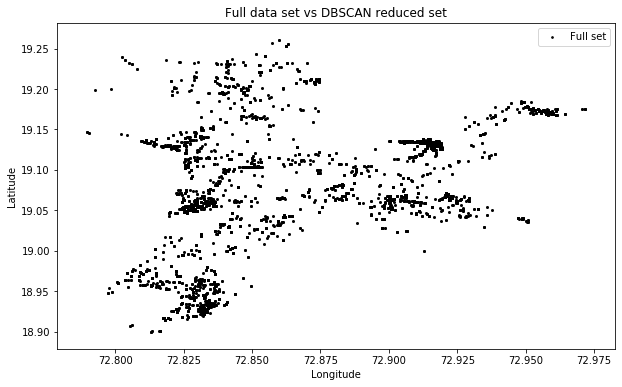

In [81]:
fig, ax = plt.subplots(figsize=[10, 6])
#rs_scatter = ax.scatter(rs['lon'], rs['lat'], c='#99cc99', edgecolor='None', alpha=0.7, s=120)
df_scatter = ax.scatter(Data['Longitude'], Data['Latitude'], c='k', alpha=0.9, s=3)
ax.set_title('Full data set vs DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter], ['Full set'], loc='upper right')
plt.show()
